[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaurabhRBhandari/UnsupervisedLearning/blob/main/gan.ipynb)

Importing necessary packages

In [111]:
import argparse
import imp
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from IPython.display import Image, display


Model hyperparameters

In [115]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
parser.add_argument("--pretained",type=bool,default=1,help="use pre-trained model")
opt,unknown = parser.parse_known_args()
print(opt)
img_shape = (opt.channels, opt.img_size, opt.img_size)

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=200, pretained=1, sample_interval=400)


In [94]:
cuda = True if torch.cuda.is_available() else False
tb=SummaryWriter()

The Generator Neural Network

In [95]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


The Discriminator Neural Network

In [96]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [97]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

Importing and pre-processing training data

In [98]:
os.makedirs("images", exist_ok=True)
# Configure data loader
# Loss function
adversarial_loss = torch.nn.BCELoss()
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

In [99]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [100]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Training

In [101]:
if(opt.pretrained^1):
    for epoch in tqdm(range(opt.n_epochs)):
        for i, (imgs, _) in enumerate(tqdm(dataloader)):
            
            # Adversarial ground truths
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            tb.add_scalar("Discriminator Loss", d_loss, epoch)
            tb.add_scalar("Generator Loss", g_loss, epoch)

            batches_done = epoch * len(dataloader) + i
            if batches_done % opt.sample_interval == 0:
                save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    torch.save(generator.state_dict(),"models/gen")
    torch.save(discriminator.state_dict(),"models/dis")

  0%|          | 0/200 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [116]:
Generator.load_state_dict(torch.load("models/gen"))
Generator.eval()
z = Variable(Tensor(np.random.normal(0, 1, (25, opt.latent_dim))))
z.to("cuda")
gen_img = Generator(z)
save_image(gen_img, "sample.png" , nrow=5, normalize=True)
display(Image('sample.png'))

TypeError: load_state_dict() missing 1 required positional argument: 'state_dict'

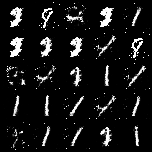